# Forecast every point in the test set using all prior days as training

70% of the data is training.
30% test.





In [140]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

In [141]:
# read in our data
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)

In [142]:
get_ticker = "IBM"
df_features = df_ORIGINAL.copy()
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head()
#Just shift close price one day back so that training model to predict one day in advance
#Remind that Backtesting is just to predict just one day in advance.
df_features['Lag'] = df_features['Adj Close'].shift(-1)
df_features['Lag'][0] = 'NAN'

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [143]:
for i in range(2,len(df_features)):
    df_features['Lag'][i] = (df_features['Adj Close'][i]/df_features['Adj Close'][i-1])-1

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [144]:
# Sanity Check
df_features = df_features.iloc[2:]
df_features.head()

Date        High         Low        Open       Close   Volume  \
2 2002-01-04  125.599999  123.980003  124.050003  125.599999  8405200   
3 2002-01-07  126.190002  123.699997  125.000000  124.050003  5939600   
4 2002-01-08  125.199997  123.730003  124.250000  124.699997  5311800   
5 2002-01-09  126.389999  124.150001  124.699997  124.489998  6839900   
6 2002-01-10  124.000000  121.419998  123.750000  122.139999  8926300   

   Adj Close       Lag  
2  87.534859  0.015688  
3  86.454575 -0.012341  
4  86.907600  0.005240  
5  86.761269 -0.001684  
6  85.123428 -0.018878

In [153]:
p=np.array(df_features[['Adj Close','Open','High','Low']])
q=np.array(df_features['Lag']).reshape(-1,1)

In [154]:
#n_days - amount of the last n_days that we whant to get prediction and calculate metrics
def backtest():
    pred = []
    true = []
    
    training_days= len(df_features.loc[df_features['Date']<'2018-01-01'])
    test_days = len(df_features.loc[df_features['Date']>='2018-01-01'])
    
    #reversed(range(1,n_days)): [n, n-1, n-2, ..., 1]
    for i in reversed(range(1, test_days)):
        
        #Suppose len(p)=30
        #[0] -> [1=30-29] -> [1,2=30-28] -> [1,2,3] -> ...
        x_train = p[:len(p)-i]
        y_train = q[:len(q)-i]
        
        #If x_train= [1,2,3], then x_test = [4]
        #Just single data
        x_test = p[len(p)-i]
        y_test = q[len(q)-i]

        model = BayesianRidge()
        model.fit(x_train, y_train.ravel())
        
        pred.append(model.predict([x_test])[0])
        true.append(y_test[0])
        

    return pred, true

In [155]:
#I want to train 2002-2017 of the whole data and 2018 for test.
true,pred = backtest()

In [156]:
#Return difference between true and prediction data
diff=np.array(true)-np.array(pred)

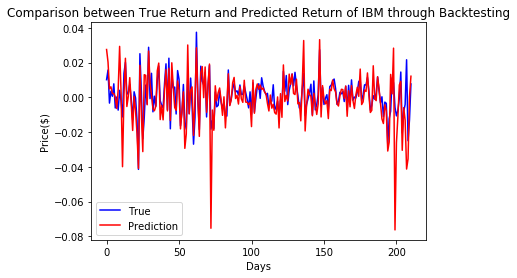

In [157]:
plt.plot(true,color='b',label='True')
plt.plot(pred,color='r',label='Prediction')
plt.xlabel('Days')
plt.ylabel('Price($)')
plt.title('Comparison between True Return and Predicted Return of %s through Backtesting' %get_ticker)
plt.legend()
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

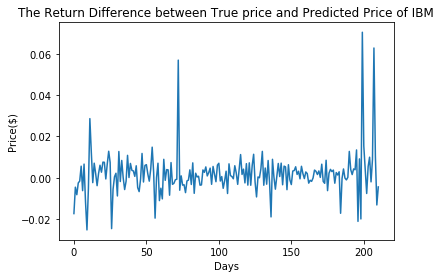

In [158]:
plt.plot(diff)
plt.xlabel('Days')
plt.ylabel('Price($)')
plt.title('The Return Difference between True price and Predicted Price of %s' %get_ticker)
plt.show